In [1]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%matplotlib inline

## Thresholding output from inference

In [2]:
proba_map_file = '../output/forward/zimmerman_01-001_subvol_x1111_y2778_z2500_soma_20_test1.tif'
proba_map = tifffile.imread(proba_map_file)

In [3]:
test_file = '../training_set/zimmerman_01-001_subvol_x1111_y2778_z2500_img_reshaped.tif'
test_map = tifffile.imread(test_file)

In [4]:
test_map.shape

(75, 278, 278)

In [5]:
proba_map.shape

(1, 75, 278, 278)

In [6]:
test_map[0].shape

(278, 278)

In [7]:
proba_map[0][0].shape

(278, 278)

Text(0, 0.5, 'Probability (from UNet inference)')

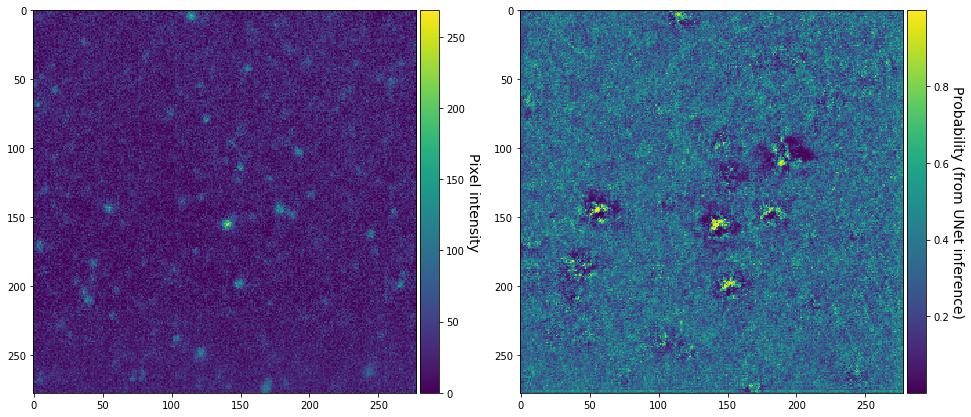

In [9]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(test_map[20], interpolation='None')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, orientation='vertical');
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Pixel intensity', rotation=270,fontsize=14)


ax2 = fig.add_subplot(122)
im2 = ax2.imshow(proba_map[0][20], interpolation='None')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im2, cax=cax, orientation='vertical');
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Probability (from UNet inference)', rotation=270,fontsize=14)

In [10]:
from scipy.ndimage.morphology import generate_binary_structure

In [13]:
structure = generate_binary_structure(3, 2) 

In [14]:
structure.shape

(3, 3, 3)

## Try to threshold probability map and find centers

In [15]:
from scipy import ndimage
def probabiltymap_to_centers_thresh(src, threshold = (0.1,1), 
    numZSlicesPerSplit = 200, overlapping_planes = 40,
    cores = 4, return_pixels = False, verbose = False, structure_rank_order = 2):
    """
    by tpisano
    
    Function to take probabilty maps generated by run_cnn and output centers based on center_of_mass
    Inputs:
    --------------
    memmapped_paths: (optional, str, or list of strs) pth(s) to memmapped array
    threshold: (tuple) lower and upper bounds to keep. e.g.: (0.1, 1) - note this assumes input from a CNN and thus data will
    numZSlicesPerSplit: chunk of zplanes to process at once. Adjust this and cores based on memory constraints.
    cores: number of parallel jobs to do at once. Adjust this and numZSlicesPerSplit based on memory constraints
    overlapping_planes: number of planes on each side to overlap by, this should be comfortably larger than the maximum z distances of a single object
    structure_rank_order: Optional. If true provides the structure element to used in ndimage.measurements.labels, 2 seems to be the most specific
    save (optional) "True", "False", str of path and file name to save with extension .p. If multiple cell /jukebox/LightSheetTransfer/cnn/zmd/20180929_395000chkpnt_xy160z20/channels.
    return_pixels, if True return centers and all pixels associated with that center
    Returns single list of
    ------------
    centers: list of zyx coordinates of centers of mass
    (IF RETURN PIXELS = True, dictionary consisting of k=centers, v=indices determined by cnn with k"s center)
    save_location (if saving)
    OUTPUTS ZYX
    """
    #handle inputs
    if type(src) == str:
        if src[-2:] == "h5":
            f = h5py.File(src)
            src = f["/main"].value
            f.close()
        elif src[-3:] == "tif": src = tifffile.imread(src)
        elif src[-3:] == "npy": src = np.load(src)
        
    src = np.squeeze(src)    
    zdim, ydim, xdim = src.shape

    #run
    if cores > 1: 
        start = time.time()
        if verbose: sys.stdout.write("\n   Thesholding, determining connected pixels, identifying center of masses\n\n"); sys.stdout.flush()
        p = mp.Pool(cores)
        iterlst=[(src, z, numZSlicesPerSplit, overlapping_planes, threshold, return_pixels, structure_rank_order) for z in range(0, zdim, numZSlicesPerSplit)]
        centers = p.starmap(helper_labels_centerofmass_thresh, iterlst)
        p.terminate()
    else:
        start = time.time()
        if verbose: sys.stdout.write("\n   Thesholding, determining connected pixels, identifying center of masses\n\n"); sys.stdout.flush()
        iterlst=[(src, z, numZSlicesPerSplit, overlapping_planes, threshold, return_pixels, structure_rank_order) for z in range(0, zdim, numZSlicesPerSplit)]
        centers = []
        for i in iterlst: 
            centers.append(helper_labels_centerofmass_thresh(i))
        

    #unpack
    if not return_pixels: centers = [zz for xx in centers for zz in xx]
    if return_pixels:
        center_pixels_dct = {}; [center_pixels_dct.update(xx[1]) for xx in centers]
        centers = [zz for xx in centers for zz in xx[0]]
        

    if verbose: print ("Total time {} minutes".format(round((time.time() - start) / 60)))
    if verbose: print("{} objects found.".format(len(centers)))

    if return_pixels: return center_pixels_dct
    return centers

def helper_labels_centerofmass_thresh(array, start, numZSlicesPerSplit, overlapping_planes, threshold, return_pixels, structure_rank_order):
    """
    by tpisano
    
    """
    zdim, ydim, xdim = array.shape

    structure = generate_binary_structure(array.ndim, structure_rank_order) if structure_rank_order else None

    #process
    if start == 0:
        arr = array[:numZSlicesPerSplit+overlapping_planes]
        #thresholding
        arr[arr<threshold[0]] = 0
        arr[arr>threshold[1]] = 0
        #find labels
        labels = ndimage.measurements.label(arr, structure); lbl_len = labels[1]
        centers = ndimage.measurements.center_of_mass(arr, labels[0], range(1, labels[1]+1)); 
        #return pixels associated with a center
        if return_pixels: dct = return_pixels_associated_w_center(centers, labels)
        del labels, arr
        assert lbl_len == len(centers), "Something went wrong, center of mass missed labels"
        #filter such that you only keep centers in first half
        centers = [center for center in centers if (center[0] <= numZSlicesPerSplit)]
        if return_pixels: dct = {c:dct[c] for c in centers}

    else: #cover 3x
        arr = array[start - overlapping_planes : np.min(((start + numZSlicesPerSplit + overlapping_planes), zdim))]
        #thresholding
        arr[arr<threshold[0]] = 0
        arr[arr>threshold[1]] = 0
        #find labels
        labels = ndimage.measurements.label(arr)
        centers = ndimage.measurements.center_of_mass(arr, labels[0], range(1, labels[1]))
        #return pixels associated with a center
        if return_pixels: dct = return_pixels_associated_w_center(centers, labels)
        del labels, arr
        #filter such that you only keep centers within middle third
        centers = [center for center in centers if (center[0] > overlapping_planes) and (center[0] <= np.min(((numZSlicesPerSplit + overlapping_planes), zdim)))]
        if return_pixels: dct = {c:dct[c] for c in centers}
        
    #adjust z plane to accomodate chunking
    centers = [(xx[0]+start, xx[1], xx[2]) for xx in centers]
    if return_pixels: 
        dct = {tuple((kk[0]+start, kk[1], kk[2])):v for kk,v in dct.iteritems()}
        return centers, dct

    return centers

In [16]:
src = np.squeeze(proba_map)    
zdim, ydim, xdim = src.shape
threshold = (0.9,1)
numZSlicesPerSplit = 200
overlapping_planes = 40
return_pixels = False
structure_rank_order = 2 
arr = src[:numZSlicesPerSplit+overlapping_planes] # keeps whole volume
 #thresholding
arr[arr<threshold[0]] = 0
arr[arr>threshold[1]] = 0
labels = ndimage.measurements.label(arr, structure)
lbl_len = labels[1]

In [17]:
lbl_len

817

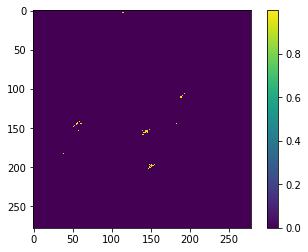

In [18]:
z_plane = 20
fig = plt.figure()
ax=fig.add_subplot(111)
im = ax.imshow(arr[z_plane])
cbar =fig.colorbar(im)

In [19]:
np.unique(labels[0][12])

array([  0,   3,  83,  92, 112, 122, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138], dtype=int32)

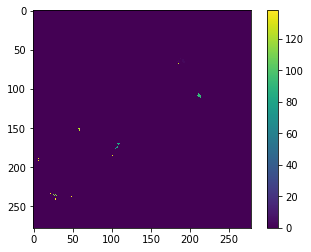

In [20]:
z_plane = 12
fig = plt.figure()
ax=fig.add_subplot(111)
im = ax.imshow(labels[0][z_plane])
cbar =fig.colorbar(im)

In [21]:
np.unique(labels[0][z_plane])

array([  0,   3,  83,  92, 112, 122, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138], dtype=int32)

In [25]:
src = np.squeeze(proba_map)    
zdim, ydim, xdim = src.shape
threshold = (0.98,1)
numZSlicesPerSplit = 200
overlapping_planes = 40
return_pixels = False
structure_rank_order = 2 
# iterlst=[(src, z,
#           numZSlicesPerSplit,
#           overlapping_planes,
#           threshold,
#           return_pixels,
#           structure_rank_order) for z in range(0, zdim, numZSlicesPerSplit)]
# centers = []
# for i in iterlst: 
#     centers.append(helper_labels_centerofmass_thresh(i))
centers = helper_labels_centerofmass_thresh(array=src, start=0, 
                                  numZSlicesPerSplit=numZSlicesPerSplit, 
                                  overlapping_planes=overlapping_planes,
                                  threshold=threshold,
                                  return_pixels=return_pixels,
                                  structure_rank_order=structure_rank_order)
print(len(centers))

218


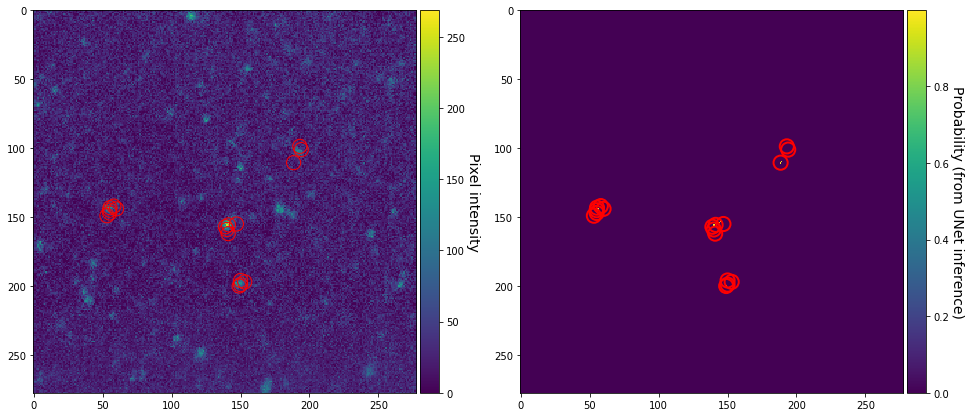

In [26]:
for z_plane in [20]:
    point_depth = 6
    centers_depth = np.array(
        [coord for coord in centers if coord[0]>=z_plane-point_depth/2. and coord[0]<z_plane+point_depth/2. ])
    xs_depth = centers_depth[:,2]
    ys_depth = centers_depth[:,1]
    fig = plt.figure(figsize=(16, 12))
    ax1 = fig.add_subplot(121)
    im1 = ax1.imshow(test_map[z_plane], interpolation='None')
    ax1.scatter(xs_depth,ys_depth,color="none",edgecolor='r',
                   marker='o',s=200,
                  linewidth=1)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical');
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Pixel intensity', rotation=270,fontsize=14)

    ax2 = fig.add_subplot(122)
    im2 = ax2.imshow(proba_map[0][z_plane], interpolation='None')
    ax2.scatter(xs_depth,ys_depth,color="none",edgecolor='r',
                   marker='o',s=200,
                  linewidth=2)
#     ax1.scatter([140],[155],color="none",edgecolor='r',
#                    marker='o',s=200,
#                   linewidth=2)
#     ax2.scatter([140],[155],color="none",edgecolor='r',
#                    marker='o',s=200,
#                   linewidth=2)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im2, cax=cax, orientation='vertical');
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Probability (from UNet inference)', rotation=270,fontsize=14)

OK, they line up well. I just needed to increase the minimum threshold.